In [1]:
import pandas as pd
%matplotlib inline
from keras.models import load_model
from keras import backend as K
import numpy as np
from sklearn.metrics import roc_curve, auc
from os import listdir
from shapely.geometry import LineString

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def generate_batch(x_left, x_right, y, size):
    while True:
        for i in xrange(0, len(x_left), size):
            x_left_b   = x_left[i:i+size]
            x_right_b  = x_right[i:i+size]
            y_b        = y[i:i+size]

            x_left_b   = np.array([np.array(row) for row in x_left_b])
            x_right_b  = np.array([np.array(row) for row in x_right_b])

            yield ([x_left_b, x_right_b], y_b)

def get_number_of_batches(dataset, b_size):
    ds_len = len(dataset)
    num_of_batches = int(round((1.0*len(test_df))/b_size))
    
    if ds_len % b_size:
        num_of_batches+=1
    
    return num_of_batches


Using Theano backend.


In [2]:
def get_metrics(y_pred, y_test, num_of_targets):
    # calculating fp_r, fa_r with different thresholds
    ones = num_of_targets[1]
    zeros = num_of_targets[0]
    fp = 0
    fa = 0
    eer = 0
    fp_r = []
    fa_r = []
    thresholds = np.linspace(0.0, 1.0, num=30)

    y_pred_thresh = []

    for t in thresholds:
        for y in y_pred:
            if y < t:
                y_pred_thresh.append(0)
            else:
                y_pred_thresh.append(1)

        for y in zip(y_pred_thresh, y_test):
            if y[1] == 1 and y[0] == 0:
                fp+=1
            if y[1] == 0 and y[0] == 1:
                fa+=1
        fp_r.append(100*(fp*1.0)/ones)
        fa_r.append(100*(fa*1.0)/zeros)
        fp = 0
        fa = 0
        y_pred_thresh = []
    
    line1 = LineString(zip(thresholds, fp_r))
    line2 = LineString(zip(thresholds, fa_r))
    
    eer = line1.intersection(line2).y
    return {'fp_r': fp_r, 'fa_r': fa_r, 'thresholds': thresholds, 'eer': eer}
    
def get_eer(y_pred, y_test, num_of_targets):
    return get_metrics(y_pred, y_test, num_of_targets)['eer']

def get_model_list(path):
    return sorted(listdir(path))

def evaluate_all(model_path, test_path):
    eers = []
    model_name = []
    test_df = pd.read_pickle(test_path)
    ones = len(test_df[test_df.is_duplicate == 1])
    zeros = len(test_df[test_df.is_duplicate == 0])
    y_test       = test_df.is_duplicate.values

    x_left_test  = test_df.vec1.values
    x_right_test = test_df.vec2.values

    batch_s = 200
    batch_total = get_number_of_batches(test_df, batch_s)

    for m in get_model_list(model_path):
        current_model = load_model(path + '/' + m, custom_objects={'f1':f1, 'recall': recall, 'precision':precision})
        y_pred = current_model.predict_generator(generate_batch(x_left_test, x_right_test, y_test, batch_s),
                                                 batch_total, 
                                                 verbose=0)
        y_pred = np.reshape(y_pred, (y_pred.shape[0],))
        eers.append(get_eer(y_pred, y_test, [zeros, ones]))
        model_name.append(m)
    
    return pd.DataFrame({'eer':eers, 'model': model_name})

In [6]:
history = pd.read_pickle('history/mlp1_b100_bn_euc_dist.h5')
model = load_model('models/best_model.h5', custom_objects={'f1':f1, 'recall': recall, 'precision':precision})

/home/loopdigga/Documents/ml/ml_env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


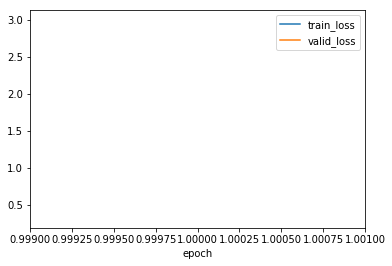

In [7]:
history.plot(y=['train_loss', 'valid_loss'], x='epoch')

In [9]:
test_df = pd.read_pickle('dataset/test/test.h5')
ones = len(test_df[test_df.is_duplicate == 1])
zeros = len(test_df[test_df.is_duplicate == 0])
y_test       = test_df.is_duplicate.values

x_left_test  = test_df.vec1.values
x_right_test = test_df.vec2.values

In [11]:
def generate_batch(x_left, x_right, y, size):
    while True:
        for i in xrange(0, len(x_left), size):
            x_left_b   = x_left[i:i+size]
            x_right_b  = x_right[i:i+size]
            y_b        = y[i:i+size]

            x_left_b   = np.array([np.array(row) for row in x_left_b])
            x_right_b  = np.array([np.array(row) for row in x_right_b])

            yield ([x_left_b, x_right_b], y_b)

def get_number_of_batches(dataset, b_size):
    ds_len = len(dataset)
    num_of_batches = int(round((1.0*len(test_df))/b_size))
    
    if ds_len % b_size:
        num_of_batches+=1
    
    return num_of_batches

In [12]:
batch_s = 200
batch_total = get_number_of_batches(test_df, batch_s)


y_pred = model.predict_generator(generate_batch(x_left_test, x_right_test, y_test, batch_s),
                                 batch_total, 
                                 verbose=0)

In [13]:
pred_name='mlp1_b100_bn_euc_dist.h5'

In [14]:
np.save('predictions/{}'.format(pred_name), y_pred)

In [15]:
y_pred = np.load('predictions/{}.npy'.format(pred_name))
y_pred = np.reshape(y_pred, (y_pred.shape[0],))

In [16]:
# calculating fp_r, fa_r with different thresholds
fp = 0
fa = 0
eer = 0
fp_r = []
fa_r = []
thresholds = np.linspace(0.0, 1.0, num=30)

y_pred_thresh = []

for t in thresholds:
    for y in y_pred:
        if y < t:
            y_pred_thresh.append(0)
        else:
            y_pred_thresh.append(1)

    for y in zip(y_pred_thresh, y_test):
        if y[1] == 1 and y[0] == 0:
            fp+=1
        if y[1] == 0 and y[0] == 1:
            fa+=1
    fp_r.append(100*(fp*1.0)/ones)
    fa_r.append(100*(fa*1.0)/zeros)
    fp = 0
    fa = 0
    y_pred_thresh = []
    

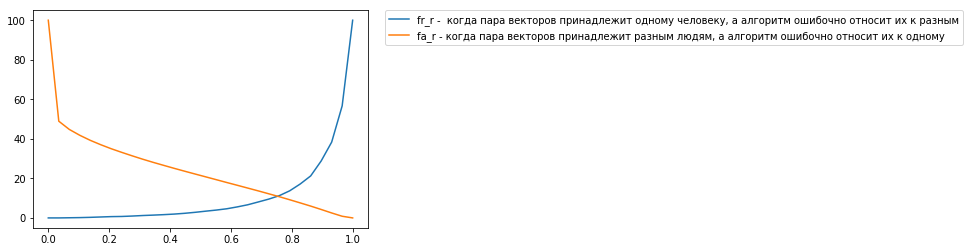

EER - 10.9736484481


In [18]:
import matplotlib.pyplot as plt
plt.plot(thresholds, fp_r, label=u'fr_r -  когда пара векторов принадлежит одному человеку, а алгоритм ошибочно относит их к разным')
plt.plot(thresholds, fa_r, label=u'fa_r - когда пара векторов принадлежит разным людям, а алгоритм ошибочно относит их к одному')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

from shapely.geometry import LineString

line1 = LineString(zip(thresholds, fp_r))
line2 = LineString(zip(thresholds, fa_r))

print('EER - {}'.format(line1.intersection(line2).y))

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=np.around(y_pred))

0.78673715026409308

In [20]:
y_pred = np.reshape(y_pred, (y_pred.shape[0],))

count    907256.000000
mean          0.230925
std           0.311684
min           0.000001
25%           0.000963
50%           0.030585
75%           0.429803
max           0.999058
Name: preds, dtype: float64

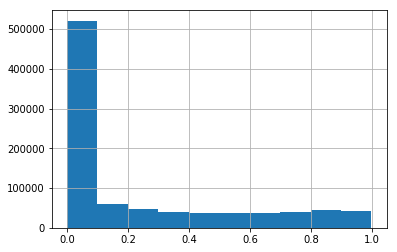

In [54]:
df = pd.DataFrame({'preds':y_pred})
df.preds.hist()
df.preds.describe()